In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import data_setup, download_data, engine, plot_loss_curves, set_seeds
from torch import nn
from torchvision.transforms import v2
from torchinfo import summary


device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Data

In [2]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data.download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [3]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [4]:
IMG_SIZE = 224

manual_transforms = v2.Compose([
    v2.Resize(size=(IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
)


### 2.2 Turn images into `DataLoader`'s

In [50]:
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f8ad6b4d40>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [51]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

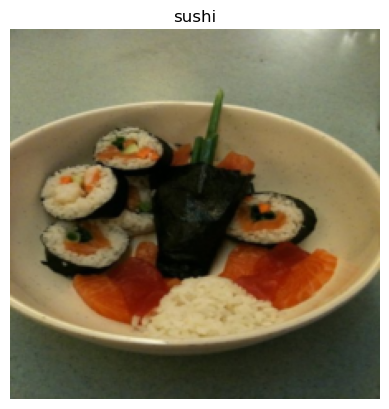

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT paper: an overview

### Calculating path embedding input and output shapes by hand

In [8]:
# Create example values
heights = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((heights * width) / patch_size ** 2)
print(f"Number of patches (N) with image height (H={heights}), width(W={width}), and patch size(P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width(W=224), and patch size(P=16): 196


In [9]:
embedding_layer_input_shape = (heights, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2*color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning a single image into patches

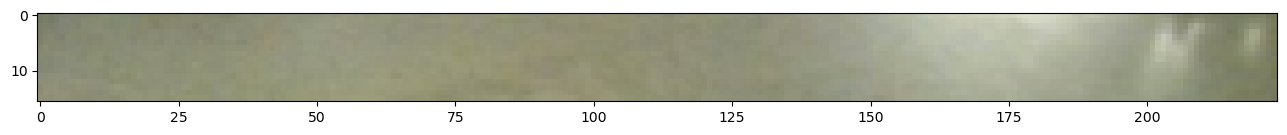

In [10]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size:16 pixels x 16 pixels


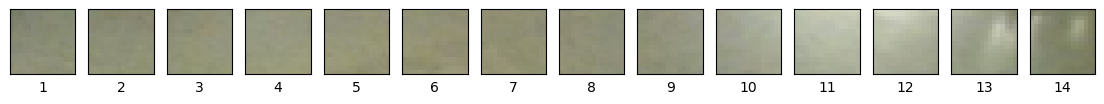

In [11]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size ==0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size:{patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


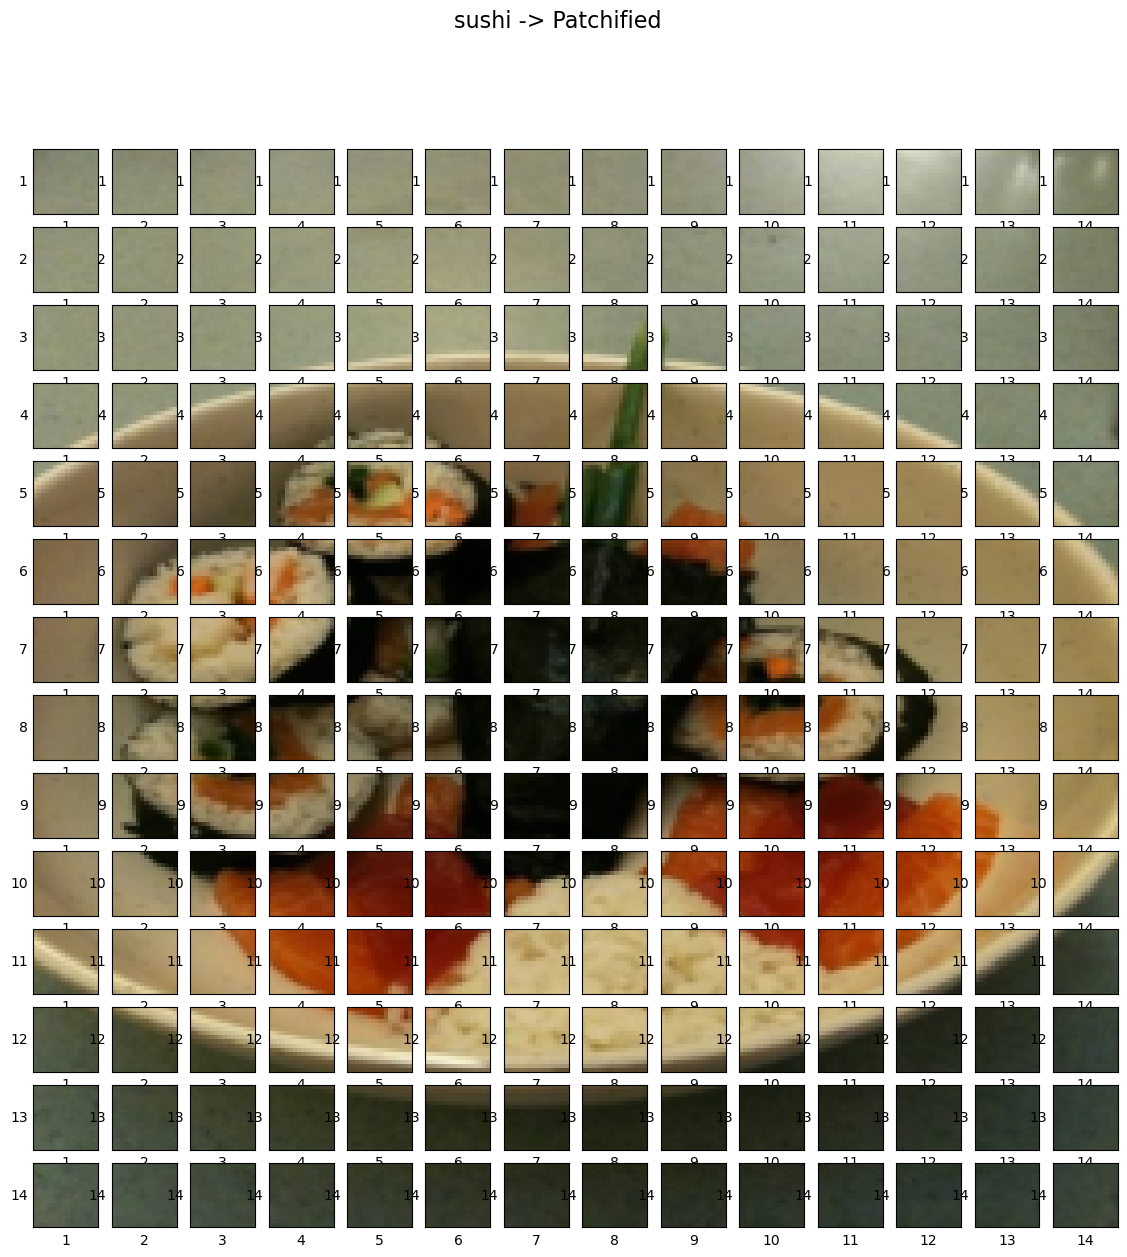

In [12]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=img_size // patch_size,
    ncols=img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Creating image patches with `torch.nn.Conv2d()`

In [13]:
from torch import nn

# Set the patch size
patch_size =16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

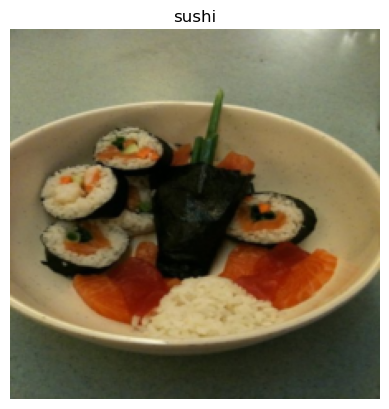

In [14]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [15]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [641, 311, 399, 307, 174]


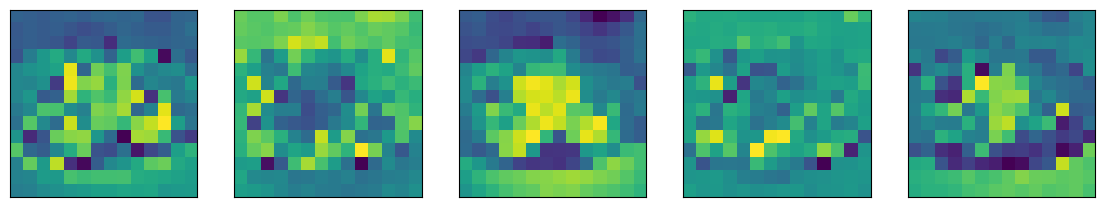

In [16]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(14, 14))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [17]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.4742, -0.4871, -0.5031, -0.5136, -0.5195, -0.4963, -0.4938,
           -0.4869, -0.4950, -0.5473, -0.5904, -0.5426, -0.4863, -0.4530],
          [-0.5112, -0.5083, -0.5198, -0.5188, -0.5373, -0.5617, -0.5191,
           -0.4882, -0.4831, -0.5075, -0.5136, -0.4902, -0.4580, -0.4324],
          [-0.5114, -0.5001, -0.5175, -0.5456, -0.5204, -0.5981, -0.5205,
           -0.5435, -0.5445, -0.4730, -0.4710, -0.4659, -0.4347, -0.4151],
          [-0.4959, -0.5514, -0.5088, -0.4101, -0.3576, -0.3875, -0.4850,
           -0.3570, -0.5359, -0.4881, -0.5299, -0.5218, -0.4406, -0.4338],
          [-0.3991, -0.4048, -0.3347, -0.4748, -0.5438, -0.3371, -0.2788,
           -0.2597, -0.4707, -0.5366, -0.5526, -0.5973, -0.5499, -0.4963],
          [-0.4587, -0.3699, -0.5416, -0.4296, -0.1780, -0.0202, -0.0840,
           -0.1962, -0.2550, -0.5028, -0.5202, -0.5367, -0.5558, -0.5210],
          [-0.4519, -0.5021, -0.5947, -0.3685, -0.2387, -0.0912, -0.1125,
           -0.1366, -0.1286, -0.

### Flattening the patch embedding with `torch.nn.Flatten()`

In [18]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} ->  [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) ->  [batch, embedding_dim, feature_map_height, feature_map_width]


In [19]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


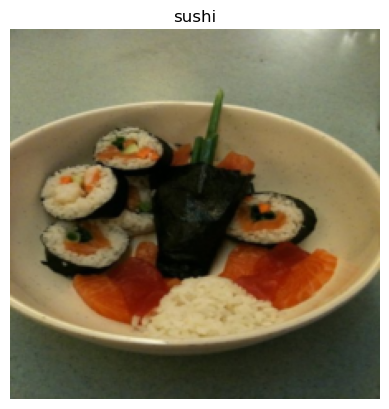

In [20]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flatten image feature map shape: {image_out_of_conv_flattened.shape}")

In [21]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


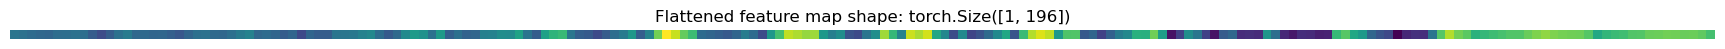

In [22]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [23]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.4742, -0.4871, -0.5031, -0.5136, -0.5195, -0.4963, -0.4938, -0.4869,
          -0.4950, -0.5473, -0.5904, -0.5426, -0.4863, -0.4530, -0.5112, -0.5083,
          -0.5198, -0.5188, -0.5373, -0.5617, -0.5191, -0.4882, -0.4831, -0.5075,
          -0.5136, -0.4902, -0.4580, -0.4324, -0.5114, -0.5001, -0.5175, -0.5456,
          -0.5204, -0.5981, -0.5205, -0.5435, -0.5445, -0.4730, -0.4710, -0.4659,
          -0.4347, -0.4151, -0.4959, -0.5514, -0.5088, -0.4101, -0.3576, -0.3875,
          -0.4850, -0.3570, -0.5359, -0.4881, -0.5299, -0.5218, -0.4406, -0.4338,
          -0.3991, -0.4048, -0.3347, -0.4748, -0.5438, -0.3371, -0.2788, -0.2597,
          -0.4707, -0.5366, -0.5526, -0.5973, -0.5499, -0.4963, -0.4587, -0.3699,
          -0.5416, -0.4296, -0.1780, -0.0202, -0.0840, -0.1962, -0.2550, -0.5028,
          -0.5202, -0.5367, -0.5558, -0.5210, -0.4519, -0.5021, -0.5947, -0.3685,
          -0.2387, -0.0912, -0.1125, -0.1366, -0.1286, -0.3655, -0.4450, -0.4000,
          -0.571

### Turning the ViT patch embedding layer into a PyTorch module

In [24]:
# 1.Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
        super().__init__()
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        
        # 4. Create a layer to flatten the patch feature maps into a single dimension
        # only flatten the feature map dimensions into a single vector
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. Make sure the output shape has the right order
        # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
        return x_flattened.permute(0, 2, 1)

In [25]:
set_seeds.set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embeded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embeded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [26]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Creating the class token embedding 

In [27]:
# View the patch embedding and patch embedding shape
print(patch_embeded_image)
print(f"Patch embedding shape: {patch_embeded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5727,  0.1462, -0.1844,  ...,  0.4206, -0.2421,  0.2083],
         [-0.5706,  0.1447, -0.1791,  ...,  0.4202, -0.2371,  0.2057],
         [-0.5974,  0.1660, -0.1671,  ...,  0.4424, -0.2633,  0.2063],
         ...,
         [-0.2158,  0.0487, -0.1062,  ...,  0.1837, -0.0804,  0.0807],
         [-0.2298,  0.0745, -0.0995,  ...,  0.1854, -0.0951,  0.0711],
         [-0.2689,  0.0809, -0.0951,  ...,  0.2125, -0.1272,  0.0831]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [28]:
# Get the batch size and embedding dimension
batch_size = patch_embeded_image.shape[0]
embedding_dimension = patch_embeded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(size=(batch_size, 1, embedding_dimension)), requires_grad=True)

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [29]:
# Add the class token embedding to the front of the patch embedding
patch_embeded_image_with_class_embedding = torch.cat((class_token, patch_embeded_image), dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embeded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embeded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5727,  0.1462, -0.1844,  ...,  0.4206, -0.2421,  0.2083],
         [-0.5706,  0.1447, -0.1791,  ...,  0.4202, -0.2371,  0.2057],
         ...,
         [-0.2158,  0.0487, -0.1062,  ...,  0.1837, -0.0804,  0.0807],
         [-0.2298,  0.0745, -0.0995,  ...,  0.1854, -0.0951,  0.0711],
         [-0.2689,  0.0809, -0.0951,  ...,  0.2125, -0.1272,  0.0831]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding

In [30]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embeded_image_with_class_embedding, patch_embeded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5727,  0.1462, -0.1844,  ...,  0.4206, -0.2421,  0.2083],
          [-0.5706,  0.1447, -0.1791,  ...,  0.4202, -0.2371,  0.2057],
          ...,
          [-0.2158,  0.0487, -0.1062,  ...,  0.1837, -0.0804,  0.0807],
          [-0.2298,  0.0745, -0.0995,  ...,  0.1854, -0.0951,  0.0711],
          [-0.2689,  0.0809, -0.0951,  ...,  0.2125, -0.1272,  0.0831]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [31]:
# Calculate N (number of patches)
number_of_patches = int((heights * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embeded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(size=(1, number_of_patches+1, embedding_dimension)), requires_grad=True)

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embeded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape}  -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4273, 1.1462, 0.8156,  ..., 1.4206, 0.7579, 1.2083],
         [0.4294, 1.1447, 0.8209,  ..., 1.4202, 0.7629, 1.2057],
         ...,
         [0.7842, 1.0487, 0.8938,  ..., 1.1837, 0.9196, 1.0807],
         [0.7702, 1.0745, 0.9005,  ..., 1.1854, 0.9049, 1.0711],
         [0.7311, 1.0809, 0.9049,  ..., 1.2125, 0.8728, 1.0831]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768])  -> [batch_size, number_of_patches, embedding_dimension]


### Putting it all together: from image to embedding

In [33]:
set_seeds.set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding Layer
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(size=(batch_size, 1, embedding_dimension)), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(size=(1, number_of_patches + 1, embedding_dimension)), requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multi-Head Attention (MSA)

### 5.1 The LayerNorm (LN) layer

### 5.2 The Multi-Head Self Attention (MSA) layer

### 5.3 Replicating Equation 2 with PyTorch layers

In [34]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Create a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self, embedding_dim: int = 768, num_heads: int=12, attn_dropout: float = 0):
        super().__init__()
        
        # 3. Create the Norm Layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)
    
    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [35]:
# Creat an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP)

### 6.1 The MLP layer(s)

In [36]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perception block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout: float=0.1):
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [37]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Create the Transformer Encoder

### 7.1 Creating a Transformer Encoder by combining our custom made layers

In [38]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self, embedding_dim: int=768, num_heads: int=12, mlp_size: int=3072, mlp_dropout: float=0.1, attn_dropout:float=0):
        super().__init__()
        
        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)
    
    # 5. Create a forward() method
    def forward(self, x):
        # 6. Create residual connection for MSA block (add the input to the output)
        x = self.msa_block(x) + x
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x
        return x

In [39]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=18,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape        Output Shape       Param #            Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]      [1, 197, 768]      --                 True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]      [1, 197, 768]      --                 True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]      [1, 197, 768]      1,536              True
│    └─MultiheadAttention (multihead_attn)         --                 [1, 197, 768]      2,362,368          True
├─MLPBlock (mlp_block)                             [1, 197, 768]      [1, 197, 768]      --                 True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]      [1, 197, 768]      1,536              True
│    └─Sequential (mlp)                            [1, 197, 768]      [1, 197, 768]      --                 True
│    │    └─Linear (0)                             [1, 197, 768]      [1, 197, 3072]     2,

### 7.2 Create a Transformer Encoder with PyTorch's Transformer layers

In [40]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [41]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all together to create ViT

In [45]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        img_size: int = 224, # Train resolution from Table 3 in ViT paper
        in_channels: int = 3, # Numer of channels in input image
        patch_size: int = 16, # Patch size
        num_transformer_layers: int = 12, # Layers from Table 1 for ViT-Base
        embedding_dim: int = 768, # Hidden size D from Table 1 for ViT-Base
        mlp_size: int = 3072, # MLP size from Table 1 for ViT-Base
        num_heads: int = 12, # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0, # Dropout for attention projection
        mlp_dropout: float = 0.1, # Dropout for patch and position embeddings
        embedding_dropout: float = 0.1, # Dropout for patch and position embeddings
        num_classes: int = 1000
    ):
        super().__init__()
        
        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (heights * width / patch^2)
        self.num_patches = (img_size * img_size) // patch_size ** 2
        
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(size=(1, 1, embedding_dim)), requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(size=(1, self.num_patches+1, embedding_dim)), requires_grad=True)
        
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder using nn.Sequential())
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout
            ) for _ in range(num_transformer_layers)]
        )
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        
        # 12. Get batch_size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" mean to infer the dimension (try this line on its own)
        
        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)
        
        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)
        
        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x
        
        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)
        
        # 18. Pass patch, position and class embedding through transformer encode layers (equations 2 & 3)
        x = self.transformer_encoder(x)
        
        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index
        
        return x

In [46]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [47]:
set_seeds.set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to out ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [49]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
ViT (ViT)                                                    [32, 3, 224, 224]  [32, 3]            152,064            True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]  [32, 196, 768]     --                 True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]  [32, 768, 14, 14]  590,592            True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]  [32, 768, 196]     --                 --
├─Dropout (embedding_dropout)                                [32, 197, 768]     [32, 197, 768]     --                 --
├─Sequential (transformer_encoder)                           [32, 197, 768]     [32, 197, 768]     --                 True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]     [32, 197, 768]     --                 True
│    │    └─Mul

## 9. Setting up training code for our ViT model

In [52]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds.set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1692 | train_acc: 0.3516 | test_loss: 4.9538 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.0649 | train_acc: 0.3164 | test_loss: 1.4446 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1835 | train_acc: 0.4414 | test_loss: 1.7670 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2579 | train_acc: 0.2695 | test_loss: 1.2907 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1495 | train_acc: 0.2852 | test_loss: 1.1928 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1942 | train_acc: 0.3047 | test_loss: 1.2281 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2601 | train_acc: 0.2852 | test_loss: 1.1504 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1030 | train_acc: 0.4258 | test_loss: 1.1980 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1501 | train_acc: 0.3047 | test_loss: 1.0164 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2638 | train_acc: 0.2617 | test_loss: 1.3953 | test_acc: 0.2604


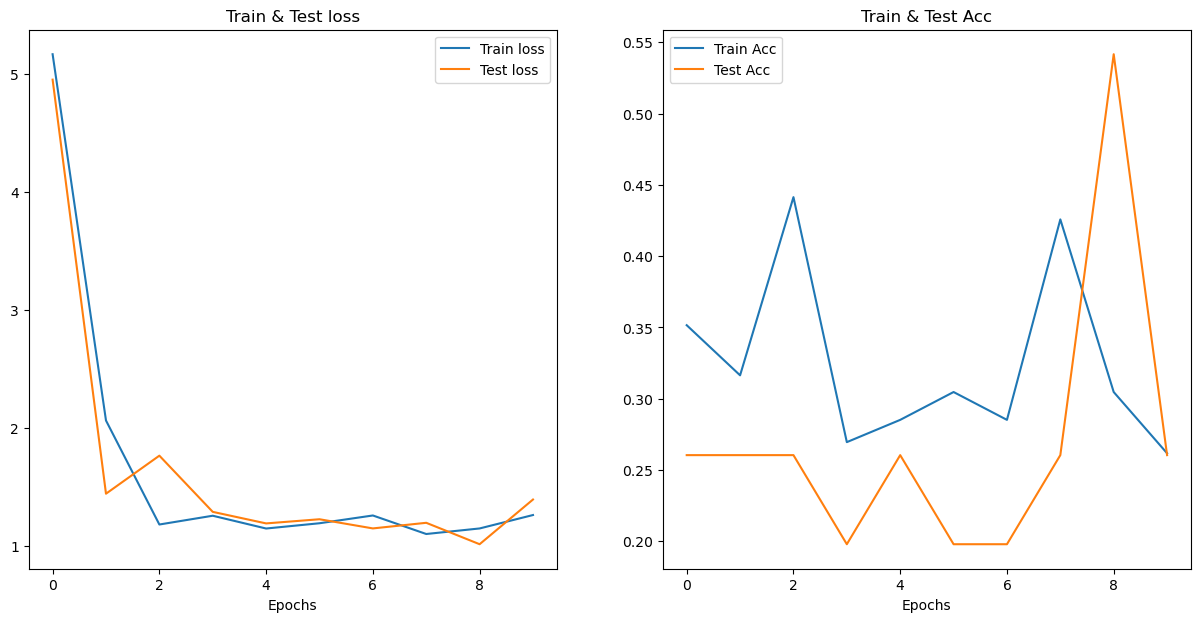

In [53]:
from plot_loss_curves import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

In [54]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.5.1
0.20.1


'cuda'

In [56]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds.set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### 10.3 Preparing data for the pretrained ViT model

In [57]:
# Download pizza, steak, sushi images from Github

image_path = download_data.download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)

image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [58]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [59]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()

pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [60]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform=pretrained_vit_transforms,
    batch_size = 32
)

### 10.4 Train feature extractor ViT model

In [61]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=1e-3
)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds.set_seeds()
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10, 
    device=device
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5436 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1243 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2341 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2267 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2063 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


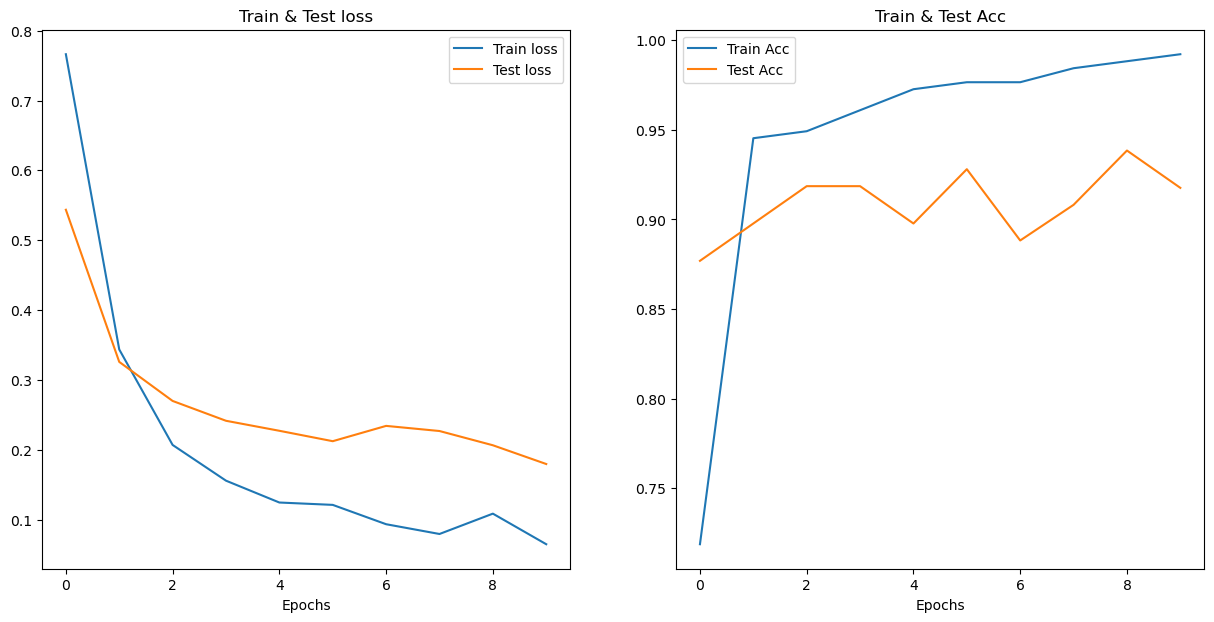

In [62]:
plot_loss_curves(pretrained_vit_results)

### 10.6 Save feature extractor ViT model and check file size

In [63]:
# Save the model
from chapter07.ch07_Experiment_Tracking.going_modular.going_modular import utils
utils.save_model(
    model=pretrained_vit,
    target_dir="models",
    model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth"
)

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [66]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)# division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Make predictions on a custom image

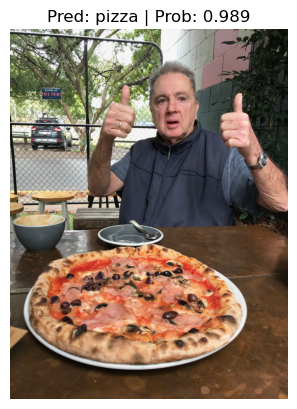

In [67]:
import requests

# Import function to make predictions on images and plot them
from chapter07.ch07_Experiment_Tracking.going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)